# Assigment 3

In [1]:
import numpy as np 
import pandas as pd 

from matplotlib.pyplot import subplots 
from plotnine import *

import statsmodels.api as sm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from functools import partial
from sklearn.model_selection import ( \
    cross_validate,
    KFold,
    ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

from sklearn.utils import shuffle

from tqdm import tqdm

import warnings

import json

import seaborn as sns
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo 



## Fetch data


In [ ]:
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 
  
# metadata 
print(communities_and_crime.metadata) 
  
# variable information 
print(communities_and_crime.variables) 


{'uci_id': 183, 'name': 'Communities and Crime', 'repository_url': 'https://archive.ics.uci.edu/dataset/183/communities+and+crime', 'data_url': 'https://archive.ics.uci.edu/static/public/183/data.csv', 'abstract': 'Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1994, 'num_features': 127, 'feature_types': ['Real'], 'demographics': ['Race', 'Age', 'Income', 'Occupation'], 'target_col': ['ViolentCrimesPerPop'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2002, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C53W3X', 'creators': ['Michael Redmond'], 'intro_paper': {'ID': 405, 'type': 'NATIVE', 'title': 'A data-driven software tool for enabling cooperative information s

In [3]:
X = X.drop(['state', 'county', 'community', 'communityname', 'fold'], axis=1)
X.replace('?', np.nan, inplace=True)

null_counts = X.isnull().sum()

# Filter columns with more than 0 nulls
null_counts = null_counts[null_counts > 0]

# Identify columns where conversion to numeric fails
for col in X.columns:
    try:
        X[col] = pd.to_numeric(X[col], errors='raise')
    except ValueError:
        print(f"Column '{col}' contains non-numeric values")

X['OtherPerCap'] = X['OtherPerCap'].fillna(X['OtherPerCap'].mean()) # Since there is 1 value missing, we replace with the mean

null_counts.drop('OtherPerCap', inplace=True) # We drop the 'OtherPerCap' from null_count table since this column has no missing values anymore
X.drop(null_counts.index.to_list(), axis=1, inplace=True) # For other, since there is too many missing, values, we drop this features from X


## Ridge and Lasso Regression
Use ridge and lasso regression from scikit-learn

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Define the Ridge model
ridge = Ridge()

# Define the parameter grid for alpha (regularization parameter)
ridge_params = {'alpha': np.logspace(-4, 4, 50)} # Will search for the best alpha between 1e-4 and 1e4

# Use GridSearchCV for parameter tuning
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_log_error')
# In the assignment 2, i've set k = 5 for cross validation and scoring method = MSLE
ridge_cv.fit(X_train, y_train)

# Get the best alpha and fit the model with it
best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_best = Ridge(alpha=best_alpha_ridge)
ridge_best.fit(X_train, y_train)

# Evaluate the Ridge model
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_best.predict(X_train)))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_best.predict(X_test)))

In [ ]:
# Define the Lasso model
lasso = Lasso(max_iter=10000)

# Define the parameter grid for alpha
lasso_params = {'alpha': np.logspace(-4, 4, 50)} # Will search for the best alpha between 1e-4 and 1e4

# Use GridSearchCV for parameter tuning
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_log_error') 
# In the assignment 2, i've set k = 5 for cross validation and scoring method = MSLE
lasso_cv.fit(X_train, y_train)

# Get the best alpha and fit the model with it
best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_best = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_best.fit(X_train, y_train)

# Evaluate the Lasso model
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_best.predict(X_train)))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_best.predict(X_test)))

In [27]:
# Compare my MSLE to the one of scikit-learn :
from sklearn.metrics import mean_squared_log_error

def MSLE(y,y_hat):
    '''
    y : real value
    y_hat : predicted value
    '''
    return np.mean((np.log1p(y) - np.log1p(y_hat)) ** 2)

y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]
print(f'MSLE by hand: {MSLE(y_true, y_pred)}')
print(f'Scikit-learn MSLE: {mean_squared_log_error(y_true,y_pred)}')

MSLE by hand: 0.03973012298459379
Scikit-learn MSLE: 0.03973012298459379


Since they are exactly the same, i can indeed compare the results given above to my results in Assignment 2:

In [28]:
# Results
print(f'Optimal alpha for Ridge: {best_alpha_ridge}')
print(f'Ridge Training MSLE: {ridge_train_rmse}')
print(f'Ridge Testing MSLE: {ridge_test_rmse} \n')

print(f'Optimal alpha for Lasso: {best_alpha_lasso}')
print(f'Lasso Training MSLE: {lasso_train_rmse}')
print(f'Lasso Testing MSLE: {lasso_test_rmse}\n')

print(f'Foward attribute selection (Assign. 2) Testing MSLE: {0.009970941816606946}')

Optimal alpha for Ridge: 494.1713361323828
Ridge Training MSLE: 0.1570655999206054
Ridge Testing MSLE: 0.1458397852109156 

Optimal alpha for Lasso: 0.0062505519252739694
Lasso Training MSLE: 0.14873610839158657
Lasso Testing MSLE: 0.13811502943789059

Foward attribute selection (Assign. 2) Testing MSLE: 0.009970941816606946


In this case, the Mean Squared Log-Error (MSLE) is better on the model selected by the foward attribute selection than other models selected by the Ridge and Lasso. We might try to change the alpha bounds to really deepen the search in the areas where MSLE is getting lower. Let's do it:

In [34]:
ridge_params # Let us try a linspace between 3.39322177e+02 and 7.19685673e+02

{'alpha': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
        4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
        2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
        9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
        4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
        1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
        8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
        3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
        1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
        7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
        3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
        1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
        6.86648845e+03, 1.00000000e+04])}

In [35]:
lasso_params # Let us try a linspace between 4.29193426e-03 and 9.10298178e-03

{'alpha': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
        4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
        2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
        9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
        4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
        1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
        8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
        3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
        1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
        7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
        3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
        1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
        6.86648845e+03, 1.00000000e+04])}

In [ ]:
# Define the parameter grid for alpha (regularization parameter)
ridge_params = {'alpha': np.linspace(3.39322177e+02, 7.19685673e+02, 50)} # Best previous alpha was around 494

# Use GridSearchCV for parameter tuning
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_log_error')
# In the assignment 2, i've set k = 5 for cross validation and scoring method = MSLE
ridge_cv.fit(X_train, y_train)

# Get the best alpha and fit the model with it
best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_best = Ridge(alpha=best_alpha_ridge)
ridge_best.fit(X_train, y_train)

# Evaluate the Ridge model
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_best.predict(X_train)))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_best.predict(X_test)))


# Define the parameter grid for alpha
lasso_params = {'alpha': np.linspace(4.29193426e-03, 9.10298178e-03, 50)} # Best previous alpha was around 6.25e-03

# Use GridSearchCV for parameter tuning
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_log_error') 
# In the assignment 2, i've set k = 5 for cross validation and scoring method = MSLE
lasso_cv.fit(X_train, y_train)

# Get the best alpha and fit the model with it
best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_best = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_best.fit(X_train, y_train)

# Evaluate the Lasso model
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_best.predict(X_train)))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_best.predict(X_test)))

In [42]:
# Results
print(f'Optimal alpha for Ridge: {best_alpha_ridge}')
print(f'Ridge Training MSLE: {ridge_train_rmse}')
print(f'Ridge Testing MSLE: {ridge_test_rmse} \n')

print(f'Optimal alpha for Lasso: {best_alpha_lasso}')
print(f'Lasso Training MSLE: {lasso_train_rmse}')
print(f'Lasso Testing MSLE: {lasso_test_rmse}\n')

print(f'Foward attribute selection (Assign. 2) Testing MSLE: {0.009970941816606946}')

Optimal alpha for Ridge: 424.70990059183674
Ridge Training MSLE: 0.15462509125894539
Ridge Testing MSLE: 0.14383381473884121 

Optimal alpha for Lasso: 1.0099315374444207
Lasso Training MSLE: 0.2358756931864259
Lasso Testing MSLE: 0.22121471043809454

Foward attribute selection (Assign. 2) Testing MSLE: 0.009970941816606946


Well it did not change that much. Next step is deepen the alpha range to find optimal alpha for ridge and lasso.

In [44]:
# Get the coefficients from Lasso
lasso_coefficients = pd.Series(lasso_best.coef_, index=X.columns)

# Select non-zero coefficients (features selected by Lasso)
selected_features_lasso = lasso_coefficients[lasso_coefficients != 0].index.tolist()

print("Features selected by Lasso regression:", selected_features_lasso)

# Assume 'selected_features_forward' contains the features selected by forward selection from the previous assignment.
selected_features_forward = ['PctIlleg', 'FemalePctDiv', 'racePctWhite', 'HousVacant',
                            'pctWWage', 'PctPersDenseHous', 'racepctblack', 'pctUrban'] 

print("Features selected by foward selection (Assign. 2):", selected_features_forward, '\n')

# Compare with forward selection
common_features = set(selected_features_lasso).intersection(set(selected_features_forward))
unique_to_lasso = set(selected_features_lasso) - set(selected_features_forward)
unique_to_forward = set(selected_features_forward) - set(selected_features_lasso)

print(f"Common features between Lasso and forward selection: {common_features}")
print(f"Features selected only by Lasso: {unique_to_lasso}")
print(f"Features selected only by forward selection: {unique_to_forward}")


Features selected by Lasso regression: ['racePctWhite', 'pctUrban', 'MalePctDivorce', 'PctKids2Par', 'PctIlleg', 'PctPersDenseHous', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'LemasPctOfficDrugUn']
Features selected by foward selection (Assign. 2): ['PctIlleg', 'FemalePctDiv', 'racePctWhite', 'HousVacant', 'pctWWage', 'PctPersDenseHous', 'racepctblack', 'pctUrban'] 

Common features between Lasso and forward selection: {'racePctWhite', 'HousVacant', 'pctUrban', 'PctPersDenseHous', 'PctIlleg'}
Features selected only by Lasso: {'PctKids2Par', 'PctHousOccup', 'LemasPctOfficDrugUn', 'PctVacantBoarded', 'MalePctDivorce'}
Features selected only by forward selection: {'racepctblack', 'FemalePctDiv', 'pctWWage'}


We can see that Lasso selected 7 features and foward selection 10 over 100. Moreover, both methods selected 5 features in common. That might imply the strong effect of these 4 features (`racePctWhite`, `HousVacant`, `pctUrban`, `PctPersDenseHous` and `PctIlleg`) on the prediction of the target in linear regression.

Remebering that the target is the number of violent crimes per population, the people intersted at these type of crimes to prevent those might want to look at these 5 features in priority, assuming that the model is well suited. It could be a start for them, not the truth.

## Wine quality with gradient descent and SGD 
### Fetch the data & Cleaning :

In [2]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

There is no missing values neither are categorical features, so don't need to deal with it.

In [5]:
X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [6]:
y.head()

,quality
0,5
1,5
2,5
3,6
4,5


Let us look at the outliers.

In [79]:
def outlier_summary(df):
    outlier_info = {}

    for column in df.select_dtypes(include=['float', 'int']):  # Only numerical columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_proportion = outlier_count / df.shape[0]

        outlier_info[column] = {
            'Outlier Count': outlier_count,
            'Outlier Proportion': outlier_proportion
        }
    
    return pd.DataFrame(outlier_info).T  # Transpose for better readability

outlier_summary_df = outlier_summary(X)
print(outlier_summary_df) # I use the 'Data Wrangler' extension of VSCode to better see the results.

                      Outlier Count  Outlier Proportion
fixed_acidity                 357.0            0.054948
volatile_acidity              377.0            0.058027
citric_acid                   509.0            0.078344
residual_sugar                118.0            0.018162
chlorides                     286.0            0.044020
free_sulfur_dioxide            62.0            0.009543
total_sulfur_dioxide           10.0            0.001539
density                         3.0            0.000462
pH                             73.0            0.011236
sulphates                     191.0            0.029398
alcohol                         3.0            0.000462


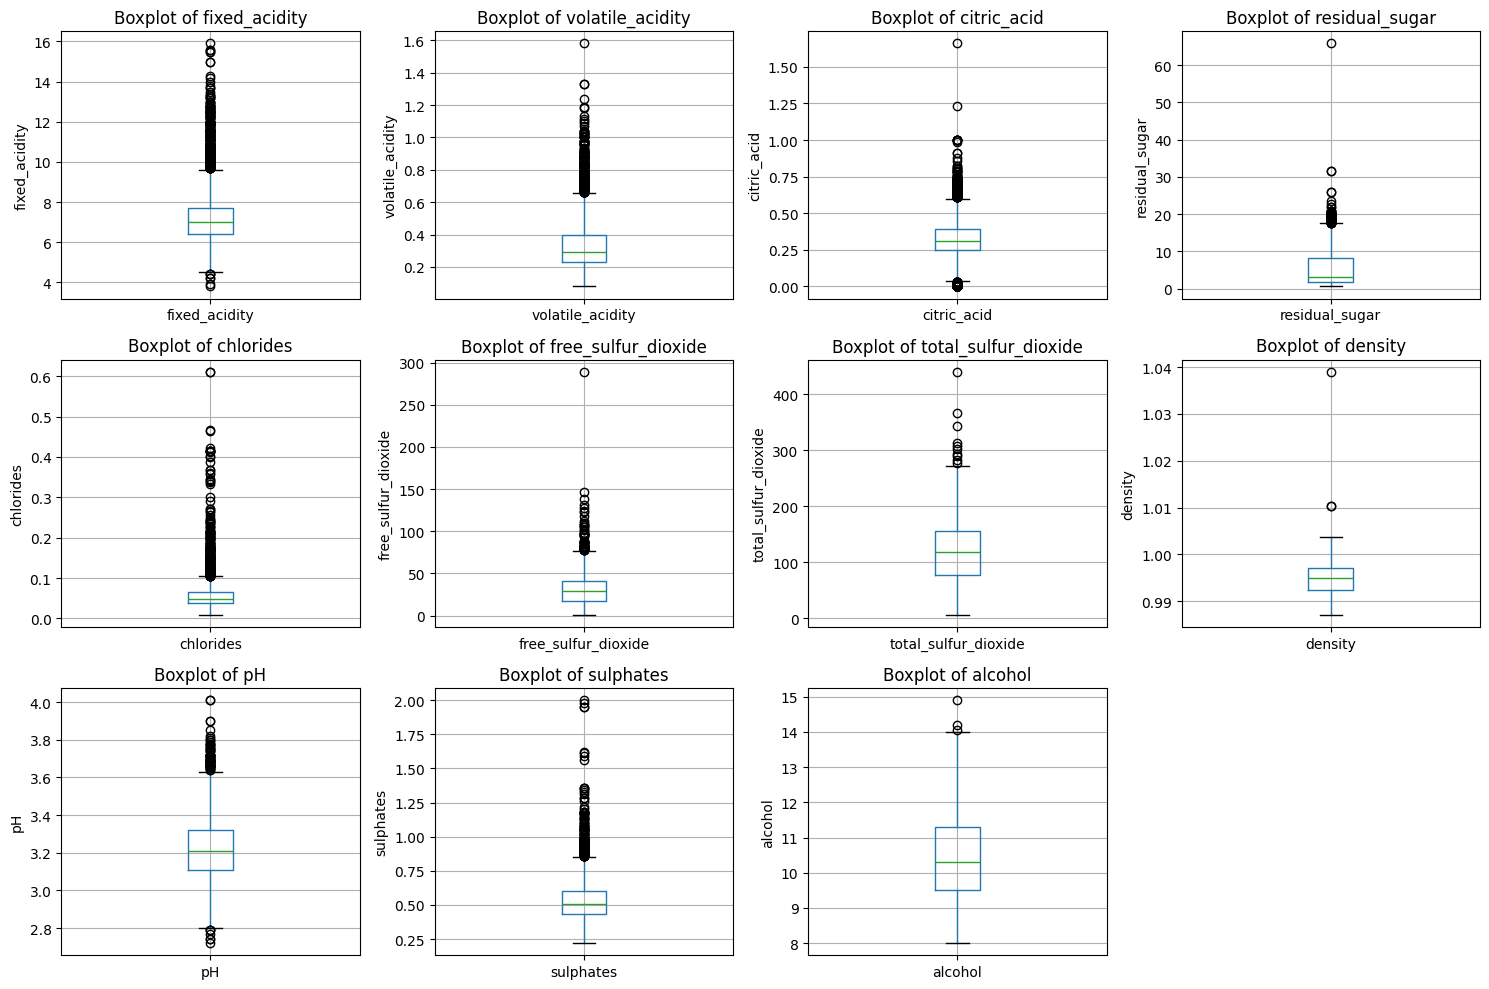

In [7]:
# Let us print boxplots

# Define the number of rows and columns for the subplots
n_rows, n_cols = 3, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()  # Flatten to easily iterate through each subplot

# Plot each feature in X
for i, column in enumerate(X.columns[:n_rows * n_cols]):  # Ensure we don't exceed available axes
    X.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel(column)

# Hide any extra subplots if we have fewer than 12 features
for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


There seems to have a lot of outliers. We might apply `RobustScaler` because it is easier to use MSE for gradient descent since we have to derive the Loss Function.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Maybe implement this:
from sklearn.preprocessing import RobustScaler
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adding a column of zeros to modelize the intercept.
X_train_scaled = np.c_[np.ones(X_train.shape[0]), X_train_scaled] # concatenate over the second axis in order to X = [[1,vector_1],[1,vector_2],...]
X_test_scaled = np.c_[np.ones(X_test.shape[0]), X_test_scaled]

### Implementation of Ridge Regression with Gradient Descent and SGD

1. **Ridge Regression Objective Function**:
   - The Ridge Regression loss function with regularization parameter $ \alpha $ is:
     $$
     \begin{align*}
      L(\mathbf{w}) &= (y - \hat y)^2 + \lambda z^2 \\
      &= \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \mathbf{w}^T \mathbf{x}_i \right)^2 + \frac{\alpha}{2} \|\mathbf{w}\|_2^2 
     \end{align*}
     $$
   - The first term is the *Mean Squared Error*, and the second term is the *L2 regularization term* that penalizes large weights.

2. **Compute the Gradient of the Loss Function**:
   - For the gradient descent update, calculate the gradient with respect to each weight $ w_j $:
     $$
     \frac{\partial L}{\partial w_j} = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \mathbf{w}^T \mathbf{x}_i \right) x_{ij} + \alpha w_j
     $$
   - In vectorized form, the gradient for all weights $ \mathbf{w} $ can be computed as:
     $$
     \nabla L = -\frac{1}{n} \mathbf{X}^T (\mathbf{y} - \mathbf{X} \mathbf{w}) + \alpha \mathbf{w}
     $$

3. **Set up the Gradient Descent Update Rule**:
   - Start with random weights $ \mathbf{w} $.
   - For each iteration (epoch), update $ \mathbf{w} $ using the gradient:
     $$
     \mathbf{w} \leftarrow \mathbf{w} - \eta \nabla L
     $$
   - Here, $ \eta $ is the learning rate, which controls the step size.

4. **Implementing Gradient Descent (GD)**:
   - **Loop through each epoch**, compute the gradient using the full dataset, and update the weights.
   - Continue iterating until you reach the maximum number of epochs or until the change in the loss function is smaller than a specified tolerance.

5. **Implementing Stochastic Gradient Descent (SGD)**:
   - In each epoch, instead of calculating the gradient using the entire dataset, compute it for each sample (or a small batch).
   - For each sample $ (\mathbf{x}_i, y_i) $, compute:
     $$
     \mathbf{w} \leftarrow \mathbf{w} - \eta \left( -\left( y_i - \mathbf{w}^T \mathbf{x}_i \right) \mathbf{x}_i + \alpha \mathbf{w} \right)
     $$
   - With SGD, the weights are updated more frequently, allowing faster convergence but with more noise in the updates.


#### Ridge with Gradient Descent

**Things to do:**
- Modify ridge_regression_gd to save a array/df that saves cost for the itearation ✅

In [5]:
def ridge_cost(X,y,w,alpha):
    # Nombre d'exemples
    n = len(y)
    
    # Calcul des prédictions
    y_pred = X.dot(w)
    
    # Calcul de l'erreur quadratique moyenne
    mse = np.sum((y - y_pred) ** 2) / (2 * n)
    
    # Calcul du terme de régularisation Ridge
    ridge_term = (alpha / 2) * np.sum(w ** 2)
    
    # Coût total
    cost = mse + ridge_term
    return cost

In [ ]:
def ridge_regression_gd(X_train_imp, X_test_imp, y_train_imp, y_test_imp, alpha=1.0, 
                        learning_rate=.1, epoch=1000, eps=1e-6, tqdm_disable=''):
    '''
    imp means implicit so the function doesn't take global variables. It avoid unecessary bugs.

    tqdm_disable : char
        If it is empty, it enables tqdm progression, but if there is a charcter or a string, disable tqdm progression.
        Disable progresson it when it is too heavy to watch the process of the loops, especially when this function is 
        called numerous times.
    '''
    n_samples, n_features = X_train_imp.shape

    w = np.random.randn(n_features) # initialize at zero. Maybe should try to randomize
    w = np.zeros(n_features)

    gd_iterations_df = pd.DataFrame(columns=['iteration','cost'])
    gd_iterations_df_idx = 0

    for epoch in tqdm(range(epoch), disable=tqdm_disable): # We ajust the weights on the whole dataset for each epoch in GD.
        # prediction
        y_hat_imp = X_train_imp@w

        # compute the gradient
        gradient = (-1/n_samples) * np.dot(X_train_imp.T, (y_train_imp - y_hat_imp)) + alpha * w

        # update the weights
        w -= learning_rate * gradient

        # save each 10 steps to trace plots
        if (epoch % 1 == 0):
            this_cost = ridge_cost(X_test_imp, y_test_imp, w, alpha)
            gd_iterations_df.loc[gd_iterations_df_idx] = [epoch, this_cost]
            gd_iterations_df_idx += 1

        if np.linalg.norm(gradient) < eps:
            print(f'Converged at epoch: {epoch}')
            break # we leave the loop if the we converged pass a certain tolerence epsilon
    
    return w, gd_iterations_df

In [ ]:
weights_1, gd_iterations_df_1 = ridge_regression_gd(X_train_scaled, X_test_scaled, y_train['quality'].to_numpy(),
                                                     y_test['quality'].to_numpy(), alpha=1.0, learning_rate=0.1)
weights_01, gd_iterations_df_01 = ridge_regression_gd(X_train_scaled, X_test_scaled, y_train['quality'].to_numpy(), 
                                                      y_test['quality'].to_numpy(), alpha=1.0, learning_rate=0.01)

  8%|▊         | 82/1000 [00:00<00:01, 636.11it/s]


Converged at epoch: 82


 87%|████████▋ | 869/1000 [00:00<00:00, 910.58it/s]

Converged at epoch: 869


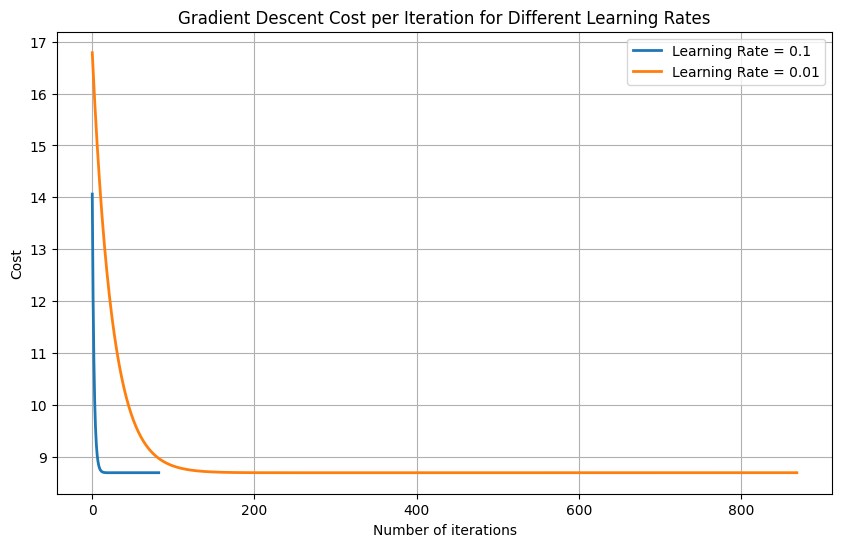

In [8]:
# Plot the cost for both learning rates over iterations
plt.figure(figsize=(10, 6))

# Plot for learning rate = 0.1
plt.plot(gd_iterations_df_1['iteration'], gd_iterations_df_1['cost'], label='Learning Rate = 0.1', linewidth=2)

# Plot for learning rate = 0.01
plt.plot(gd_iterations_df_01['iteration'], gd_iterations_df_01['cost'], label='Learning Rate = 0.01', linewidth=2)

# Add labels and title
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Gradient Descent Cost per Iteration for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()


#### Ridge with SGD

In [ ]:
def ridge_regression_sgd(X_train_imp, X_test_imp, y_train_imp, y_test_imp, batch_size=1, alpha=1.0, learning_rate=.1, 
                         epoch=1000, eps=0.1, patience = 3, tqdm_disable = ''):
    '''
    imp means implicit so the function doesn't take global variables. It avoid unecessary bugs.
    we add batch_size parameter that indicate on how much of the dataset we compute the `stochastic_gradient` on

    tqdm_disable : char
        If it is empty, it enables tqdm progression, but if there is a charcter or a string, disable tqdm progression.
        Disable progresson it when it is too heavy to watch the process of the loops, especially when this function is 
        called numerous times.
    '''
    n_samples, n_features = X_train_imp.shape

    w = np.random.randn(n_features) # initialize at zero. Maybe should try to randomize
    # w = np.zeros(n_features)

    sgd_iterations_df = pd.DataFrame(columns=['iteration','cost'])
    sgd_iterations_df_idx = 0

    prev_loss = np.inf
    no_improve_epoch = 0

    for epoch in tqdm(range(epoch), disable=tqdm_disable): 
        # We ajust the weights on shuffled part of dataset of length `batch_size` for each epoch in SGD.
        # select the dataset we want to update the weights
        X_shuffle, y_shuffle = shuffle(X_train_imp, y_train_imp)
        
        for i in range(0, n_samples, batch_size):
            X_stochastic = X_shuffle[i:i + batch_size]
            y_stochastic = y_shuffle[i:i + batch_size]
        
            # prediction
            y_hat_imp = X_stochastic@w

            # compute the gradient
            gradient = (-1/batch_size) * np.dot(X_stochastic.T, (y_stochastic - y_hat_imp)) + alpha * w

            # update the weights
            w -= learning_rate * gradient

            # save each 10 steps to trace plots (i've changed it to 1 for the grid search)
            #if (epoch % 1 == 0):
        this_cost = ridge_cost(X_test_imp, y_test_imp, w, alpha)
        sgd_iterations_df.loc[sgd_iterations_df_idx] = [epoch, this_cost]
        sgd_iterations_df_idx += 1

        if np.abs(this_cost - prev_loss) < eps:
            no_improve_epoch +=1
            if no_improve_epoch >= patience: # must at least stay consistent for 3 epoch in a row
                print(f'Stopped after epoch: {epoch + 1} due to improvement lower than {eps}.')
                break # we leave the loop if the we converged pass a certain tolerence epsilon
        else: no_improve_epoch = 0
        prev_loss = this_cost

    return w, sgd_iterations_df

In [ ]:
weights_sgd_1, sgd_iterations_df_1 = ridge_regression_sgd(X_train_scaled, X_test_scaled, y_train['quality'].to_numpy(), 
                                                          y_test['quality'].to_numpy(), batch_size=32, alpha=1.0, 
                                                          learning_rate=0.1, epoch=10)
weights_sgd_01, sgd_iterations_df_01 = ridge_regression_sgd(X_train_scaled, X_test_scaled, y_train['quality'].to_numpy(), 
                                                            y_test['quality'].to_numpy(), batch_size=32, alpha=1.0, 
                                                            learning_rate=0.001, epoch=20)

 50%|█████     | 5/10 [00:00<00:00, 136.09it/s]


Stopped after epoch: 6 due to improvement lower than 0.1.


 50%|█████     | 10/20 [00:00<00:00, 163.51it/s]

Stopped after epoch: 11 due to improvement lower than 0.1.


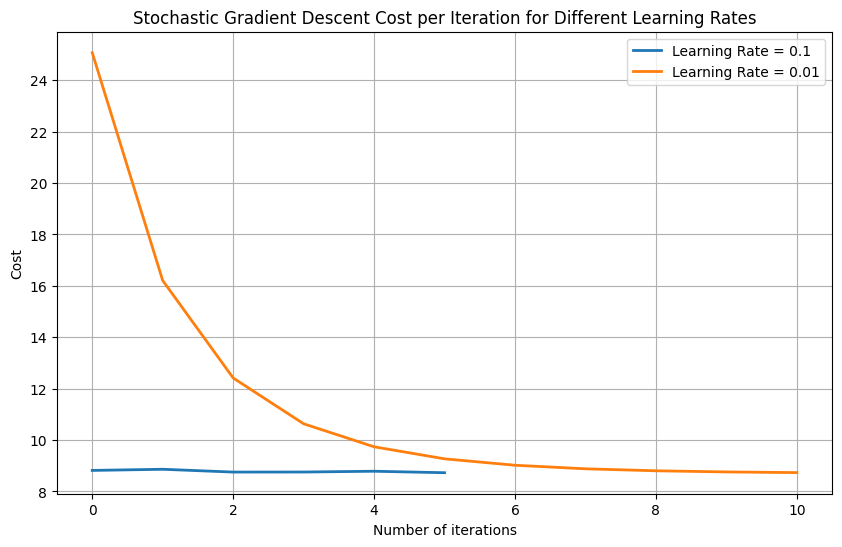

In [74]:
# Plot the cost for both learning rates over iterations
plt.figure(figsize=(10, 6))

# Plot for learning rate = 0.1
plt.plot(sgd_iterations_df_1['iteration'], sgd_iterations_df_1['cost'], label='Learning Rate = 0.1', linewidth=2)

# Plot for learning rate = 0.01
plt.plot(sgd_iterations_df_01['iteration'], sgd_iterations_df_01['cost'], label='Learning Rate = 0.01', linewidth=2)

# Add labels and title
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Stochastic Gradient Descent Cost per Iteration for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()


##### Results
We clearly see that the Stochastic Gradient Descent converges quicker than the classic Gradient Descent.
For a `learning_rate=0.1`, it looks like it converges to around $8.73$ in few iterations with the SGD (i don't know how but well) whereas it take $122$ epoch for the Gradient Descent.


#### Optimal learning rate

Now let us move to the **grid search** for an optimal `learning_rate`.

In [75]:
import sys
import contextlib

In [ ]:
learning_rates_gd = np.linspace(0.05,0.57,25)
learning_rates_sgd = np.logspace(-3,-.3,25)

# create dictionnary that will save the ..._iterations_df
gd_array = []
sgd_array = []

# Remove temporary the prints into this block :
with contextlib.redirect_stdout(None):
    for learning_rate in tqdm(learning_rates_gd, disable=''):
        # extract only the iterations dataframe
        _, gd_iterations_df = ridge_regression_gd(X_train_scaled, X_test_scaled, y_train['quality'].to_numpy(),
                                                   y_test['quality'].to_numpy(), alpha=1.0, learning_rate=learning_rate, 
                                                   tqdm_disable='yes')
        gd_array.append([learning_rate,gd_iterations_df])

    for learning_rate in tqdm(learning_rates_sgd):
        _, sgd_iterations_df = ridge_regression_sgd(X_train_scaled, X_test_scaled, y_train['quality'].to_numpy(), 
                                                    y_test['quality'].to_numpy(), batch_size=32, alpha=1.0, 
                                                    learning_rate=learning_rate, tqdm_disable='yes', epoch=20)
        sgd_array.append([learning_rate,sgd_iterations_df])
    

100%|██████████| 25/25 [00:00<00:00, 27.79it/s]


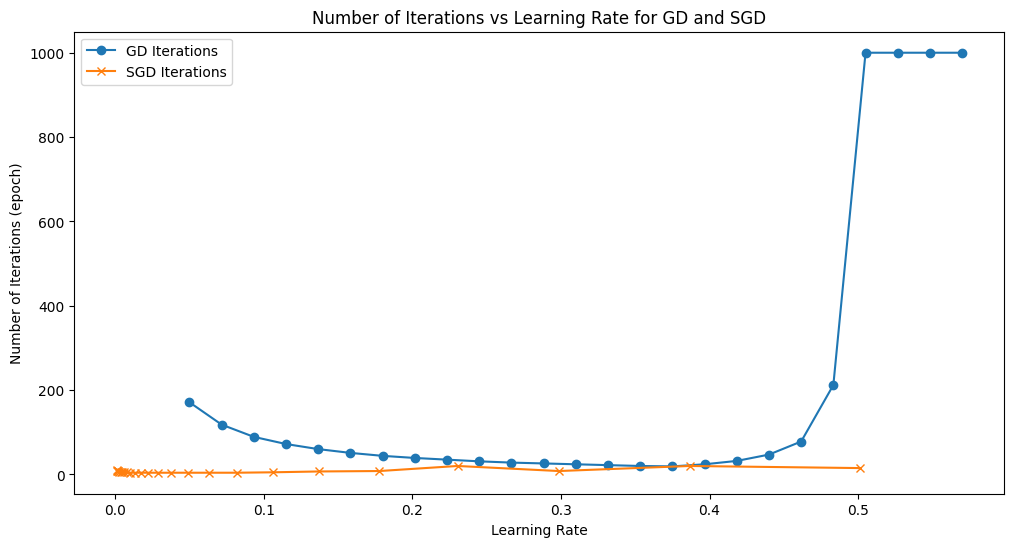

In [113]:
# Extracting learning rates and iteration counts from the sorted arrays
gd_learning_rates = [item[0] for item in gd_array]
gd_iterations = [len(item[1]) for item in gd_array]

sgd_learning_rates = [item[0] for item in sgd_array]
sgd_iterations = [len(item[1]) for item in sgd_array]

# Plotting the curves
plt.figure(figsize=(12, 6))

# Plot for Gradient Descent
plt.plot(gd_learning_rates, gd_iterations, label="GD Iterations", marker='o')
# Plot for Stochastic Gradient Descent
plt.plot(sgd_learning_rates, sgd_iterations, label="SGD Iterations", marker='x')

plt.xlabel("Learning Rate")
plt.ylabel("Number of Iterations (epoch)")
plt.title("Number of Iterations vs Learning Rate for GD and SGD")
plt.legend()
plt.show()


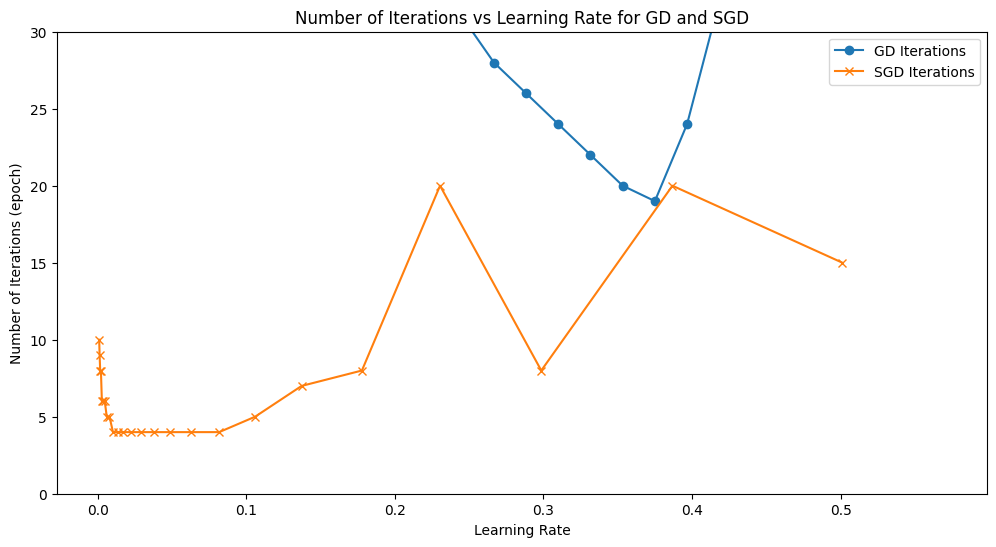

In [116]:
# Lets zoom on the lower part of the graph
plt.figure(figsize=(12, 6))

# Plot for Gradient Descent
plt.plot(gd_learning_rates, gd_iterations, label="GD Iterations", marker='o')
# Plot for Stochastic Gradient Descent
plt.plot(sgd_learning_rates, sgd_iterations, label="SGD Iterations", marker='x')

plt.ylim((0,30))
plt.xlabel("Learning Rate")
plt.ylabel("Number of Iterations (epoch)")
plt.title("Number of Iterations vs Learning Rate for GD and SGD")
plt.legend()
plt.show()

In [117]:
# Sort gd_array and sgd_array by the increasing length of the iterations DataFrame in each element
gd_array_sorted = sorted(gd_array, key=lambda item: len(item[1]))
sgd_array_sorted = sorted(sgd_array, key=lambda item: len(item[1]))

print(f'Best learning rate for Gradient Descent = {gd_array_sorted[0][0]}')
print(f'Best learning rate for Stochastic Gradient Descent = {sgd_array_sorted[0][0]}')

Best learning rate for Gradient Descent = 0.37499999999999994
Best learning rate for Stochastic Gradient Descent = 0.010292005271944281


##### Results
**Gradient Descent**:
On the graph above, we clearly see that as soon as the learning rate goes above a certain treshold (0.55), the convergence is not attaigned. We can deduce easily that for a learning rate above 0.55, the gradient will oscillate and then never converges. The quickest convergence is attainged for an learning rate $\approx 0.375$.

**Stochatsic Gradient Descent**:
To assess converence in SGD, we stopped the SGD process if the cost remained below a certain threshold for 3 consecutive epoch.
For learning rates between $0.01$ and $0.0375$ it seems that it needs less than 2 epoch to converge (check the head `sgd_array_sorted` below). In our SGD algorithm, we updated the `sgd_iterations` (containing the history of the costs) only at each epoch. To find the best learning rate, we might consider to record the cost at each batch. 

In constrast, we can see on the figure above (with ajusted y axis) that learning rates below $0.01$ and above $0.1$ takes a few epoch to converge.

In [129]:
print(f'Gradient Descent minimum cost = {gd_array_sorted[0][1]['cost'].to_numpy()[-1]}')
sgd_array_sorted[:10]

Gradient Descent minimum cost = 8.692151206602881


[[0.010292005271944281,
     iteration      cost
  0        0.0  8.754738
  1        1.0  8.700434
  2        2.0  8.701824
  3        3.0  8.695073],
 [0.01333521432163324,
     iteration      cost
  0        0.0  8.702033
  1        1.0  8.688344
  2        2.0  8.703370
  3        3.0  8.734469],
 [0.017278259805078636,
     iteration      cost
  0        0.0  8.707320
  1        1.0  8.716109
  2        2.0  8.723791
  3        3.0  8.699698],
 [0.0223872113856834,
     iteration      cost
  0        0.0  8.725331
  1        1.0  8.710043
  2        2.0  8.701167
  3        3.0  8.703454],
 [0.029006811986931547,
     iteration      cost
  0        0.0  8.717966
  1        1.0  8.710688
  2        2.0  8.714454
  3        3.0  8.695094],
 [0.037583740428844416,
     iteration      cost
  0        0.0  8.700993
  1        1.0  8.725648
  2        2.0  8.699318
  3        3.0  8.688756],
 [0.04869675251658631,
     iteration      cost
  0        0.0  8.728509
  1        1.0  8.757345

##### Fiding the optimal learning rate for SGD

Let us change the cost recording in the batch loop to assess better convergence.

In [152]:
from collections import deque # We will use this to have a deque of max length 'patience'

In [ ]:
def updated_ridge_regression_sgd(X_train_imp, X_test_imp, y_train_imp, y_test_imp, batch_size=32, alpha=1.0, 
                                 learning_rate=.1, epoch=20, eps=0.1, patience = 10, nb_of_batch_to_update_cost = 1, 
                                 tqdm_disable = ''):
    '''
    imp means implicit so the function doesn't take global variables. It avoid unecessary bugs.
    we add batch_size parameter that indicate on how much of the dataset we compute the `stochastic_gradient` on

    tqdm_disable : char
        If it is empty, it enables tqdm progression, but if there is a charcter or a string, disable tqdm progression.
        Disable progresson it when it is too heavy to watch the process of the loops, especially when this function is 
        called numerous times.

    nb_of_batch_to_update_cost : integer
        Answer to: how often do you want to update the cost?
    '''
    n_samples, n_features = X_train_imp.shape

    w = np.random.randn(n_features) # initialize at zero. Maybe should try to randomize
    # w = np.zeros(n_features)

    sgd_iterations_df = pd.DataFrame(columns=['iteration','cost'])
    sgd_iterations_df_idx = 0

    prev_losses = deque(np.zeros(20).tolist(), maxlen=20)
    prev_losses.appendleft(np.inf)
    no_improve_epoch = 0

    for epoch in tqdm(range(epoch), disable=tqdm_disable): 
        # We ajust the weights on shuffled part of dataset of length `batch_size` for each epoch in SGD.
        # select the dataset we want to update the weights
        X_shuffle, y_shuffle = shuffle(X_train_imp, y_train_imp)
        
        for i in range(0, n_samples, batch_size):
            X_stochastic = X_shuffle[i:i + batch_size]
            y_stochastic = y_shuffle[i:i + batch_size]
        
            # prediction
            y_hat_imp = X_stochastic@w

            # compute the gradient
            gradient = (-1/batch_size) * np.dot(X_stochastic.T, (y_stochastic - y_hat_imp)) + alpha * w

            # update the weights
            w -= learning_rate * gradient

            # perform a save each nb_of_batch_to_update is hitted
            if np.gcd(nb_of_batch_to_update_cost,i) == nb_of_batch_to_update_cost:
                this_cost = ridge_cost(X_test_imp, y_test_imp, w, alpha)
                sgd_iterations_df.loc[sgd_iterations_df_idx] = [sgd_iterations_df_idx, this_cost]
                sgd_iterations_df_idx += 1

                # compute mean of non zeros values of prev_losses
                pl = np.array(prev_losses) # as to go through numpy each time bcs 'queue' object doesn't have built in features as 'ndarray'
                prev_loss = np.mean(pl[pl != 0]) # actually the mean of losses of previous iterations

                if np.abs(this_cost - prev_loss) < eps:
                    no_improve_epoch +=1
                    if no_improve_epoch >= patience: # must at least stay consistent for 'patience' iterations in a row
                        print(f'Stopped after epoch {epoch + 1}, batch n°{i/batch_size}/{len(range(0, n_samples, batch_size))} due to improvement lower than {eps}.')
                        return w, sgd_iterations_df # leave the SGD if this condition is filled
                else: no_improve_epoch = 0

                prev_losses.append(this_cost) # Since it is a 'queue' object, this list has a maxsize of 'patience' !

    return w, sgd_iterations_df

In [ ]:
_, b = updated_ridge_regression_sgd(X_train_scaled, X_test_scaled, y_train['quality'].to_numpy(), y_test['quality'].to_numpy(), 
                             batch_size=32, alpha=1.0, learning_rate=0.0375, tqdm_disable='', epoch=20,
                             patience=10, eps=0.05)

b.values[-10:] # print last 10 steps

Stopped after epoch 1, batch n°63.0/163 due to improvement lower than 0.05.


array([[54.        ,  8.71349637],
       [55.        ,  8.71344893],
       [56.        ,  8.70559344],
       [57.        ,  8.71794643],
       [58.        ,  8.73474295],
       [59.        ,  8.72509984],
       [60.        ,  8.71495158],
       [61.        ,  8.73258759],
       [62.        ,  8.72060861],
       [63.        ,  8.72247065]])

In [212]:
sgd_array_2 = []

# Remove temporary the prints into this block :
with contextlib.redirect_stdout(None):
    for learning_rate in tqdm(learning_rates_sgd):
        _, sgd_iterations_df_2 = updated_ridge_regression_sgd(X_train_scaled, X_test_scaled, y_train['quality'].to_numpy(), 
                                                              y_test['quality'].to_numpy(), batch_size=32, alpha=1.0, 
                                                              learning_rate=learning_rate, tqdm_disable='yes', epoch=20,
                                                              patience=10, eps=0.05)
        sgd_array_2.append([learning_rate,sgd_iterations_df_2])
    

100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


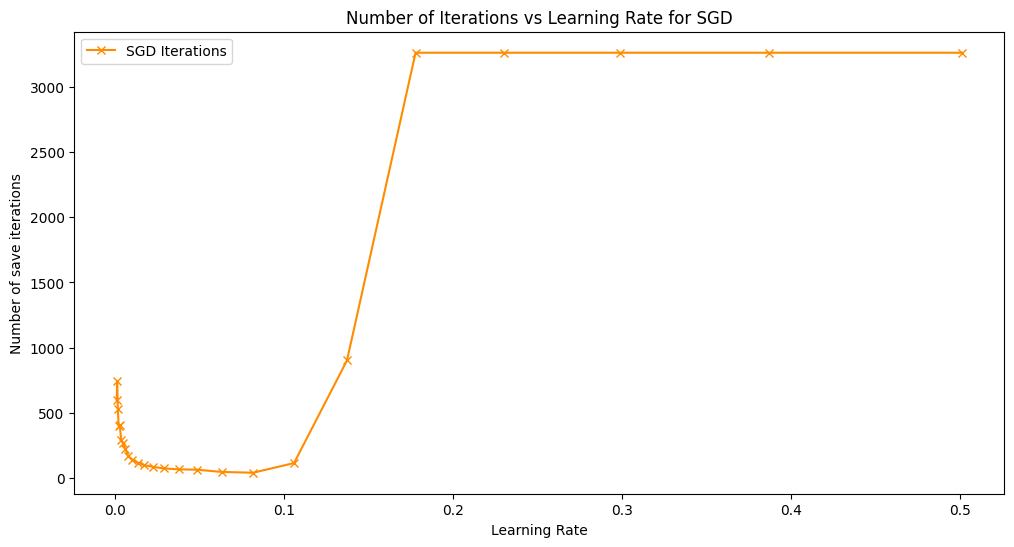

In [222]:
sgd_learning_rates_2 = [item[0] for item in sgd_array_2]
sgd_iterations_2 = [len(item[1]) for item in sgd_array_2]


plt.figure(figsize=(12, 6))

# Plot for updated Stochastic Gradient Descent
plt.plot(sgd_learning_rates_2, sgd_iterations_2, label="SGD Iterations", marker='x', c='darkorange')

plt.xlabel("Learning Rate")
plt.ylabel("Number of save iterations")
plt.title("Number of Iterations vs Learning Rate for SGD")
plt.legend()
plt.show()

In [216]:
# Sort gd_array and sgd_array by the increasing length of the iterations DataFrame in each element
sgd_array_sorted_2 = sorted(sgd_array_2, key=lambda item: len(item[1]))

print(f'Best learning rate for Stochastic Gradient Descent = {sgd_array_sorted_2[0][0]}')

Best learning rate for Stochastic Gradient Descent = 0.08175230379436502


**Now we have it!** The best learning rate for Stochastic Gradient Descent is around $0.0818$.